In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pylab as plt
from scipy.stats import norm as awgn

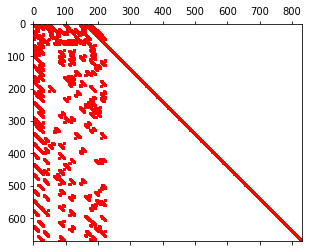

In [2]:
def get_submatrix(offset, Z):
    if offset == -1: return np.zeros((Z, Z), dtype = bool)
    offset %= Z
    if offset == 0: return np.eye(Z, dtype = bool)
    return sp.diags([np.ones(offset), np.ones(Z - offset)],
                    [offset - Z, offset], dtype = bool).toarray()

Z = 16
filler = np.vectorize(get_submatrix, otypes = [np.ndarray], signature = '()->(n,n)', excluded = (1,))
matrix = np.loadtxt('matrices/R1-1711982_BG2_set2.csv', dtype = int)
H = np.block([[x for x in row] for row in filler(matrix, Z)])


plt.spy(H, markersize = 2, color = 'r')

In [3]:
def my_permutation(B, permut, n1, n2, n3):
    v1 = B.take(n1, axis = 1)
    v2 = B.take(n2, axis = 1)
    index1, index2 = permut[n1], permut[n2]
    permut[n1], permut[n2] = index2, index1
    for i in range(v1.shape[0]):
        B[i][n2] = v1[i]
        B[i][n1] = v2[i]
        
    ones_in_n2 = list(np.where(v1 == 1)[0])
    ones_in_n2.remove(n3)
    for i in ones_in_n2:
        B[:][i] = (B[:][i] + B[:][n3]) % 2

        
def custom_gauss_elimination(H):
    B = np.copy(H)
    completed_indexes = [] 
    drop_indexes = []
    K = B.shape[0]
    N = B.shape[1]
    permut = np.arange(N)
    for k_iter in range(K):
        row = B.take(k_iter, axis = 0)
        if(sum(row) != 0):
            i = 0
            while(row[i] != 1):
                i+=1
            my_permutation(B, permut, i, N - K + k_iter, k_iter)
            completed_indexes.append(N - K + k_iter)
        else:
            drop_indexes.append(k_iter)
            
    if not drop_indexes: 
        return B, permut
    else:
        i = 0
        for drop in drop_indexes:
            H = np.delete(H, drop - i, axis=0)
            i+=1
        print("try again...")
        custom_gauss_elimination(H)
        
        
def H2G(H):
    B, permut = custom_gauss_elimination(H)
    assert B[:, -B.shape[0]:].all() == np.eye(B.shape[0], dtype = int).all()

    M = np.shape(H)[0] # N-K
    N = np.shape(H)[1] 
    K = N - M
    G = np.concatenate([np.eye(K), ((-1)*B[:, :K].T %2)], axis=1).astype(bool)
    
    A = np.copy(H)
    for j in range(H.shape[1]):
        h = H.take(permut[j], axis = 1)
        A[:, j] = h[:]
            
    assert (G @ A.T % 2).all() == np.zeros((K, K)).all()
    return G, A

In [4]:
G, A = H2G(H)

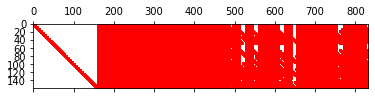

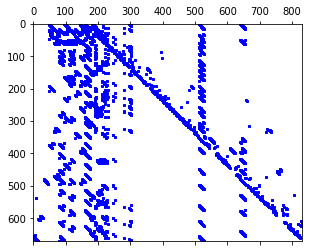

In [5]:
plt.spy(G, markersize = 2, color = 'r')
plt.show()
plt.spy(A, markersize = 2, color = 'b')
plt.show()

In [6]:
max(np.sum(H, axis = 0))

23

In [7]:
v_nodes_values = np.zeros(A.shape[1])
for c_node in range(A.shape[0]):
    v_node_list = np.where(A.take(c_node, axis = 0) == 1)[0]

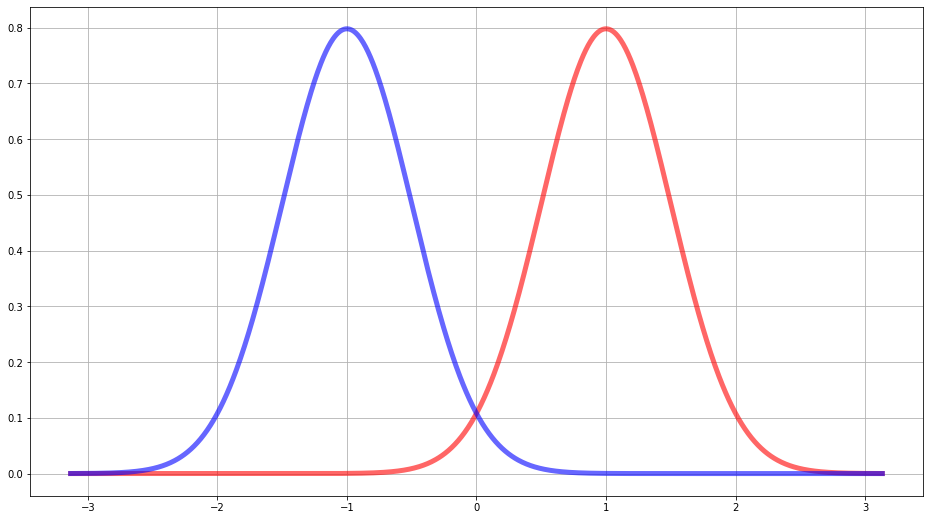

array([1.37039769, 0.59812555, 0.91265937])

In [8]:
sigma  = 0.5
args0 = {'loc': 1,  'scale': sigma}
args1 = {'loc': -1, 'scale': sigma}

x = np.linspace(awgn.ppf(1e-5, **args1),
                awgn.ppf(1 - 1e-5, **args0), 1000)

plt.figure(figsize=(16,9))
plt.plot(x, awgn.pdf(x, **args0), 'r-', lw=5, alpha=0.6, label='0')
plt.plot(x, awgn.pdf(x, **args1), 'b-', lw=5, alpha=0.6, label='1')
plt.grid()
plt.show()

awgn.rvs(size = 3, **args0)

In [9]:
def get_graph(H):
    v_graph = np.array([dict() for x in range(H.shape[1])])
    c_graph = np.array([dict() for x in range(H.shape[0])])

    for v_iter in range(H.shape[1]):
        v_graph[v_iter] = {'c_idx': np.where(H.take(v_iter, axis = 1) == 1)[0]}

    for c_iter in range(H.shape[0]):
        c_graph[c_iter] = {'v_idx': np.where(H.take(c_iter, axis = 0) == 1)[0]}
        
    return v_graph, c_graph

v_graph, c_graph = get_graph(A)

In [134]:
def MSA(H, y, SNR, max_iter = 10, threshold = 0.5):
    # SNR: Signal-Noise Ratio. SNR = 10 * lg(1 / variance) =  -20 lg (sigma) in dB.
    sigma = 10 ** (- SNR / 20)
    r = y * (2. / sigma ** 2)
    belief = r
    
    L = np.copy(H).astype(float)
    
    #initialization
    for i in range(L.shape[0]):
        L[i, :] = (L[i, :] > 0) * belief[:]

    for k in range(max_iter):
        print(k)
        #row step
        for i in range(L.shape[0]):
            magnitudes = sorted(set(abs(L[i])), reverse = False)
            magnitudes.remove(0)
            min1, min2 = list(magnitudes)[:2]
            argmin1 = np.where(abs(L[i]) == min1)[0]
            signs = np.sign(L[i])
            parity = np.sum(signs < 0) % 2

            L[i] = (L[i] != 0) * min1
            L[i][argmin1] = min2
            L[i] *= signs * (-1) ** parity

        #column step
        belief = np.sum(L, axis = 0) + r
        L = (L != 0) * (belief - L)
        
        if (sum(H @ demodulate(belief) % 2) == 0):
            return belief
        if (np.prod(np.abs(belief) > threshold)):
            return belief
        
    return belief

def demodulate(b):
    u = 0.5 * (1 - np.sign(b))
    return u.astype(bool)

def decoder(H, y, SNR):
    b = MSA(H, y, SNR = SNR)
    u = demodulate(b)
    
    s = H @ u % 2
    if sum(s) != 0: print('probably there is an error')
    return u

def encoder(G, v, SNR, seed = 2021):
    # SNR: Signal-Noise Ratio. SNR = 10 * lg(1 / variance) =  -20 lg (sigma) in dB.
    # BPSK modulation: "0" -> +1., "1" -> -1.
    
    x = 1 - 2*v
    
    sigma = 10 ** (- SNR / 20)
    np.random.seed(seed = seed)
    e = awgn.rvs(size = x.shape, scale = sigma)
    
    y = x + e
    return y

In [135]:
a = np.random.randint(low = 0, high = 2, size = G.shape[0])
v = (a @ G % 2).astype(bool)

SNR = 0.8
y = encoder(G = G, v = v, SNR = SNR)
u = decoder(H = A, y = y, SNR = SNR)

np.allclose(u, v)

0
1
2
3


True

In [128]:
@np.vectorize
def custom_func(val):
    return np.log((1 + val)/(1 - val))

H = np.array([[1,1,1,0,1,0,0],
             [0,1,1,1,0,1,0],
             [1,1,0,1,0,0,1],
            [1,0,1,0,1,1,1]])

def SPA(H, y, SNR, max_iter = 10, threshold = 0.5):
    # SNR: Signal-Noise Ratio. SNR = 10 * lg(1 / variance) =  -20 lg (sigma) in dB.
    sigma = 10 ** (- SNR / 20)
    r = y * (2. / sigma ** 2)
    
    M = np.copy(H).astype(float)
    
    #initialization
    for i in range(H.shape[0]):
        M[i, :] = r * H[i, :]

    for k in range(max_iter):
        print(k)
        
        M = np.tanh(M/2)
        for i in range(H.shape[0]):
            for j in range(H.shape[1]):
                t = np.delete(M[i][:], j)
                M[i][j] = np.prod(t, where = (t != 0))
        M = custom_func(M)

        belief = np.sum(M, axis = 0) + r
        # decode and demodulate

        # e2v
        M = (H != 0) * (belief - M)
        
        if (sum(H @ demodulate(belief) % 2) == 0):
            return belief
        if (np.prod(np.abs(belief) > threshold)):
            return belief
        
    return belief

In [132]:
a = np.random.randint(low = 0, high = 2, size = G.shape[0])
v = (a @ G % 2).astype(bool)
SNR = 0.8
y = encoder(G = G, v = v, SNR = SNR)
%prun b = SPA(A, y, SNR = SNR, max_iter = 5)
u = demodulate(b)
    
s = A @ u % 2
if sum(s) != 0: print('probably there is an error')

0
1
2
3
4
 probably there is an error
